<a href="https://colab.research.google.com/github/costaljorge/Bandas_Bollinger/blob/main/Bandas_Bollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entrada

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Carregar o conjunto de dados
df = pd.read_excel('/content/AMZN.xlsx')

# Calcular a média móvel simples (SMA) de 20 dias
df['SMA_20'] = df['Fechamento'].rolling(window=20).mean()

# Calcular o Índice de Força Relativa (RSI) de 14 dias
delta = df['Fechamento'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))
df['RSI'] = rsi

# Calcular as Bandas de Bollinger (BB)
window = 20
rolling_mean = df['Fechamento'].rolling(window).mean()
rolling_std = df['Fechamento'].rolling(window).std()
df['BB_upper'] = rolling_mean + (rolling_std * 2)
df['BB_lower'] = rolling_mean - (rolling_std * 2)

# Calcular o Oscilador Estocástico
n = 14  # Período para o Oscilador Estocástico
low_min = df['Minimo'].rolling(window=n).min()
high_max = df['Maxima'].rolling(window=n).max()
k_percent = 100 * ((df['Fechamento'] - low_min) / (high_max - low_min))
d_percent = k_percent.rolling(window=3).mean()
df['%K'] = k_percent
df['%D'] = d_percent

# Calcular o Average True Range (ATR) de 14 dias
true_range = pd.DataFrame()
true_range['TR1'] = abs(df['Maxima'] - df['Minimo'])
true_range['TR2'] = abs(df['Maxima'] - df['Fechamento'].shift())
true_range['TR3'] = abs(df['Fechamento'].shift() - df['Minimo'])
df['ATR'] = true_range.max(axis=1).rolling(window=14).mean()

# Calcular o Moving Average Convergence Divergence (MACD)
short_window = 12
long_window = 26
signal_window = 9
short_ema = df['Fechamento'].ewm(span=short_window, min_periods=1, adjust=False).mean()
long_ema = df['Fechamento'].ewm(span=long_window, min_periods=1, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['Signal_Line'] = df['MACD'].ewm(span=signal_window, min_periods=1, adjust=False).mean()

# Calcular o Volume Weighted Average Price (VWAP)
df['Typical_Price'] = (df['Minimo'] + df['Maxima'] + df['Fechamento']) / 3
df['Cumulative_TP*Volume'] = df['Typical_Price'] * df['Volume']
df['Cumulative_Volume'] = df['Volume'].cumsum()
df['VWAP'] = df['Cumulative_TP*Volume'] / df['Cumulative_Volume']

# Imprimir as primeiras linhas do DataFrame com as variáveis técnicas calculadas
#print(df.head())


## Calculo da média

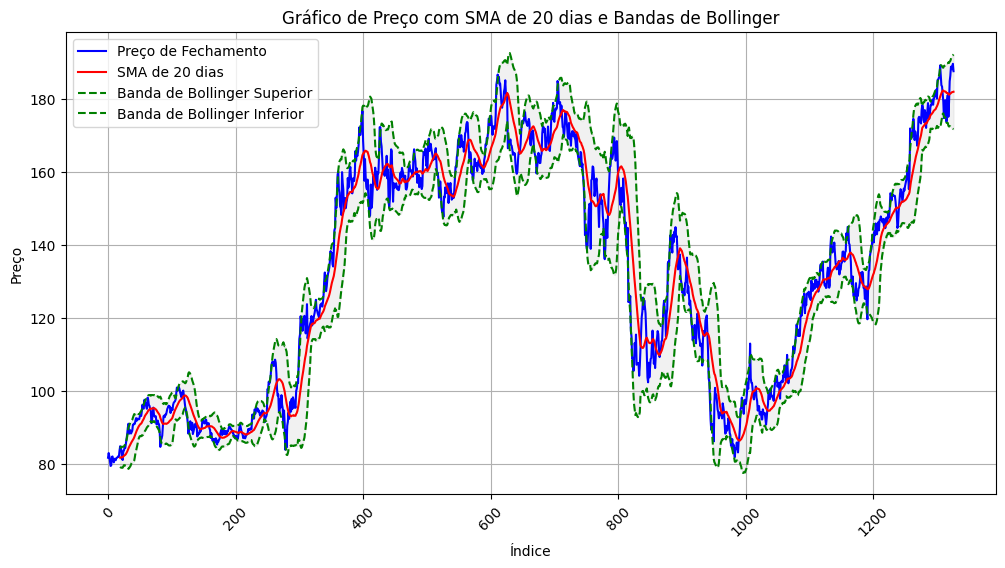

In [5]:
# Calcular a média móvel simples (SMA) de 20 dias
df['SMA_20'] = df['Fechamento'].rolling(window=20).mean()

# Calcular as Bandas de Bollinger (BB)
window = 20
rolling_mean = df['Fechamento'].rolling(window).mean()
rolling_std = df['Fechamento'].rolling(window).std()
df['BB_upper'] = rolling_mean + (rolling_std * 2)
df['BB_lower'] = rolling_mean - (rolling_std * 2)

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Fechamento'], label='Preço de Fechamento', color='blue')
plt.plot(df.index, df['SMA_20'], label='SMA de 20 dias', color='red')
plt.plot(df.index, df['BB_upper'], label='Banda de Bollinger Superior', color='green', linestyle='--')
plt.plot(df.index, df['BB_lower'], label='Banda de Bollinger Inferior', color='green', linestyle='--')
plt.fill_between(df.index, df['BB_upper'], df['BB_lower'], color='lightgray', alpha=0.3)
plt.xlabel('Índice')
plt.ylabel('Preço')
plt.title('Gráfico de Preço com SMA de 20 dias e Bandas de Bollinger')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Previsão Futura

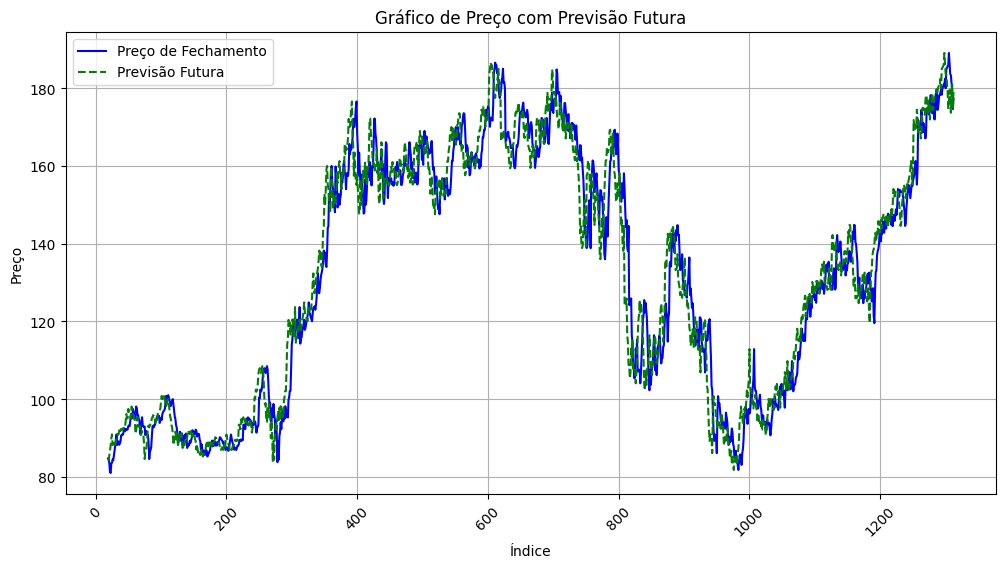

Valores Previstos e Reais para uma Semana no Futuro:
       Fechamento  Previsao
Dia 1      179.54    184.72
Dia 2      176.59    186.21
Dia 3      173.67    188.70
Dia 4      179.62    188.76
Dia 5      180.96    188.00
Dia 6      175.00    189.50
Dia 7      179.00    187.48


In [6]:
# Adicionar uma coluna de valores de previsão futura (por exemplo, 7 dias no futuro)
df['Previsao'] = df['Fechamento'].shift(-7)  # Aqui você pode usar qualquer método de previsão que preferir

# Remover as linhas com valores NaN resultantes da previsão
df = df.dropna()

# Dividir o conjunto de dados em features (X) e target (y)
X = df[['SMA_20', 'BB_upper', 'BB_lower']]  # Usando as variáveis técnicas como features para a regressão
y = df['Previsao']

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões para o conjunto de teste
y_pred = model.predict(X_test)

# Plotar o gráfico com a previsão
plt.figure(figsize=(12, 6))
plt.plot(df.index[:-7], df['Fechamento'][:-7], label='Preço de Fechamento', color='blue', linestyle='-')
plt.plot(df.index[:-7], df['Previsao'][:-7], label='Previsão Futura', color='green', linestyle='--')
plt.xlabel('Índice')
plt.ylabel('Preço')
plt.title('Gráfico de Preço com Previsão Futura')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Mostrar os valores previstos e reais para uma semana no futuro
print("Valores Previstos e Reais para uma Semana no Futuro:")
df_future = df[['Fechamento', 'Previsao']].tail(7)
df_future.index = ['Dia {}'.format(i+1) for i in range(7)]
print(df_future)
